In [1]:
# In this example, the four Galilean moons of Jupiter are downloaded from HORIZONS 
# and their orbits are integrated forwards in time.  This is a well-known example of a
# 1:2:4 resonance in orbitting bodies.
# We do a Fourier Transform of their positions in their orbits, to look for the 
# resonant structure.

import rebound
import numpy as np
sim = rebound.Simulation()
sim.units = ('AU', 'yr', 'Msun')

# We can simply add Jupiter and four of its moons by name, since REBOUND is linked to the HORIZONS database.
sim.add("Jupiter")
sim.add("Io")
sim.add("Europa")
sim.add("Ganymede")
sim.add("Callisto")

Searching NASA Horizons for 'Jupiter'... Found: Jupiter Barycenter (5).
Searching NASA Horizons for 'Io'... Found: Io (501).
Searching NASA Horizons for 'Europa'... Found: Europa (502).
Searching NASA Horizons for 'Ganymede'... Found: Ganymede (503).
Searching NASA Horizons for 'Callisto'... Found: Callisto (504).


In [2]:
# After the moons are added, we can print out the mean motions and periods of the inner three moons,
# which are in resonance:
sim.status()
os = sim.calculate_orbits()
print os[0].n,os[1].n,os[2].n
print os[0].P,os[1].P,os[2].P # yrs

---------------------------------
REBOUND version:     	2.11.0
REBOUND built on:    	Dec  5 2015 14:45:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	0.000000
Current timestep:    	0.001000
---------------------------------
<rebound.Particle object, id=0 m=0.000954791915211 x=-5.12540776413 y=1.73366866965 z=0.107488161949 vx=-0.916848798531 vy=-2.48314380103 vz=0.0308269727671>
<rebound.Particle object, id=0 m=4.4908495628e-08 x=-5.12451624968 y=1.73632818996 z=0.107595659754 vx=-4.39722498675 vy=-1.31313427926 vz=0.0205193374874>
<rebound.Particle object, id=0 m=2.41329205756e-08 x=-5.12359327267 y=1.73781065152 z=0.107699135143 vx=-3.54767842859 vy=-1.33217423583 vz=0.0409884704319>
<rebound.Particle object, id=0 m=7.45057091122e-08 x=-5.1318490578 y=1.73681430095 z=0.107522481691 vx=-1.92164654992 vy=-4.53982971459 vz=-0.0600271460843>
<rebound.Particle object, id=0 m=5.40965817457e-08 x=-5.11543192872 y=1.74120394281 z=0.107861961577 vx=-1.96125226096

In [3]:
# Can easily see that the mean motions of each moon are twice that of the moon inner to it.
# This implies the 4:2:1 resonance, which we will verified in this example.

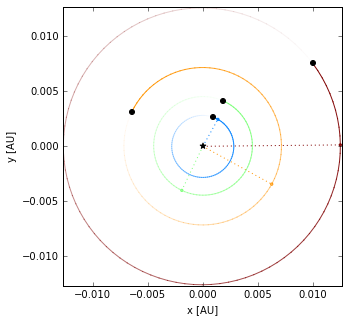

In [4]:
# Move to the COM frame and plot the orbits of the four moons around Jupiter:
sim.move_to_com()
import matplotlib.pyplot as plt
%matplotlib inline
fig = rebound.OrbitPlot(sim, unitlabel="[AU]", color=True, trails=True, periastron=True)
# REBOUND automatically plots Jupiter as the central body in this frame, complete with 
# a star symbol (not completely representative of this case, but it'll do).

In [5]:
# This example uses the whfast integrator since no close encounters are expected.  
# The timestep is set to about 10% of one of Io's orbits.
sim.integrator = "whfast"
sim.dt = 0.00008  # 10% of one day (since Io's orbit is about 2 days)
Nout = 1000000    # number of points to display
tmax = 80         # let the simulation run for 80 years
Nmoons = 4

In [6]:
# As was done in the Fourier Transforms and Resonances example, we set up several arrays to 
# hold values as the simulation runs.  This includes the positions of the moons, their semi-major
# axes, eccentricities, mean longitudes, and longitude of pericentres.
x = np.zeros((Nmoons,Nout))
a = np.zeros((Nmoons,Nout))
ecc = np.zeros((Nmoons,Nout))
longitude = np.zeros((Nmoons,Nout))
varpi = np.zeros((Nmoons,Nout))

times = np.linspace(0.,tmax,Nout)
ps = sim.particles

for i,time in enumerate(times):
    sim.integrate(time)
    # note we used above the default exact_finish_time = 1, which changes the timestep near the outputs to match
    # the output times we want.  This is what we want for a Fourier spectrum, but technically breaks WHFast's
    # symplectic nature.  Not a big deal here.
    os = sim.calculate_orbits()
    for j in range(Nmoons):
        x[j][i] = ps[j+1].x 
        a[j][i] = os[j].a
        ecc[j][i] = os[j].e
        longitude[j][i] = os[j].l
        varpi[j][i] = os[j].Omega + os[j].omega

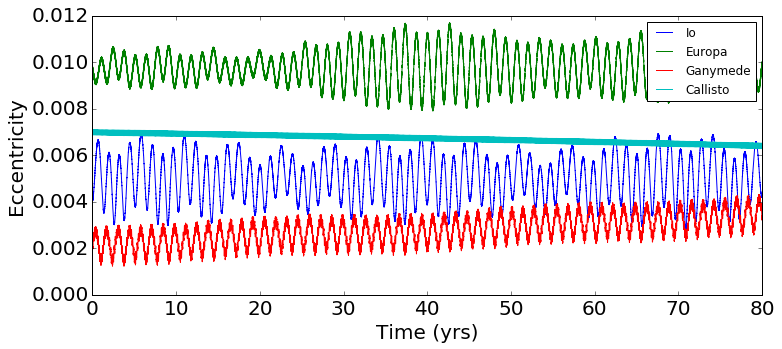

In [7]:
# If we plot the eccentricities as a function of time, you can see that they oscillate significantly for the three inner moons,
# which are in resonance with each other.  Contrasting with these large oscillations, is the smaller oscillations of the outer
# Galilean moon, Callisto, which is shown for comparison in cyan.
# The three inner moons are in resonance, 1:2:4, but Callisto is not quite in resonance with them.

# Also visible is the gradual change in eccentricity as a function of time: Callisto's eccentricity is decreasing and 
# Ganymede's eccentricity is increasing.  The secular change in their eccentricities is due to the periodic perturbation
# caused by their orbital resonances.

labels = ["Io", "Europa","Ganymede","Callisto"]
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111)

plt.plot(times,ecc[0],label=labels[0])
plt.plot(times,ecc[1],label=labels[1])
plt.plot(times,ecc[2],label=labels[2])
plt.plot(times,ecc[3],label=labels[3])

ax.set_xlabel("Time (yrs)", fontsize=20)
ax.set_ylabel("Eccentricity", fontsize=20)
ax.tick_params(labelsize=20)

plt.legend();

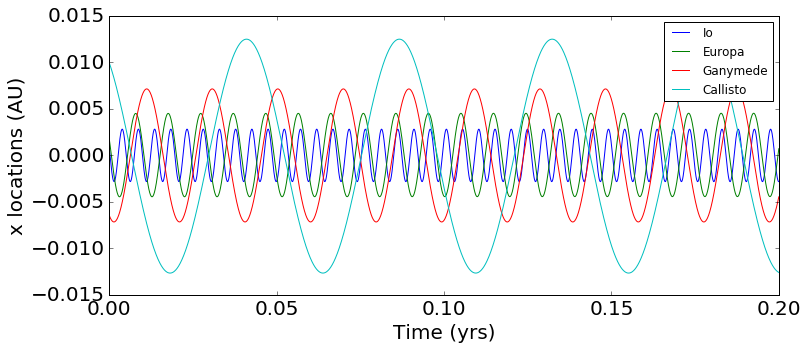

In [8]:
# We can plot their x-locations as a function of time as well:
fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111)

plt.plot(times,x[0],label=labels[0])
plt.plot(times,x[1],label=labels[1])
plt.plot(times,x[2],label=labels[2])
plt.plot(times,x[3],label=labels[3])

ax.set_xlim(0,0.2)
ax.set_xlabel("Time (yrs)", fontsize=20)
ax.set_ylabel("x locations (AU)", fontsize=20)
ax.tick_params(labelsize=20)

plt.legend();

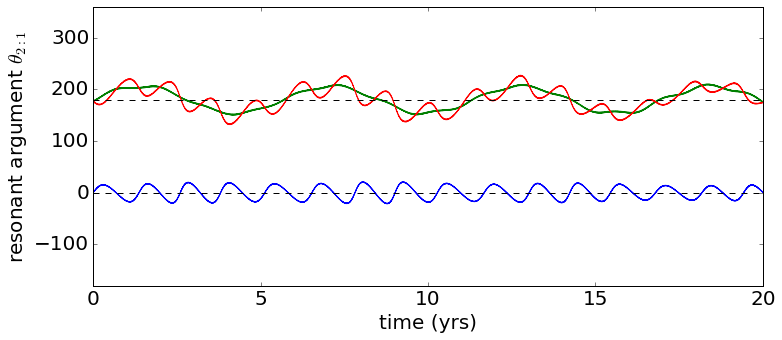

In [48]:
# Resonances are identified by looking at the resonant arguments: theta = (p + q)lambda_out - p lambda_in - q omega_out
# If these resonant arguments oscillate but are constrained within some range of angles, then 
# there is a resonance between the inner and outer bodies.
# The trick is to find what the values of q and p are.  For our case, we have two 2:1 resonances between the moons,
# so their resonant arguments would follow the function:
#    theta = 2*lambda_out - lambda_in - omega_out

# To make the plotting easier, we can borrow this helper function (puts angles into 0 to 360 degrees) 
# from the other example (Fourier Transforms and resonances), and define a new one that puts angles
# into -180 to 180 degrees.

def zeroTo360(val):
    while val < 0:
        val += 2*np.pi
    while val > 2*np.pi:
        val -= 2*np.pi
    return (val*180/np.pi)

def min180To180(val):
    while val < -np.pi:
        val += 2*np.pi
    while val > np.pi:
        val -= 2*np.pi
    return (val*180/np.pi)

# let's make this resonance angle like a boss!
theta = [min180To180(2.*longitude[1][i] - longitude[0][i] - varpi[0][i]) for i in range(Nout)]
theta1 = [zeroTo360(2.*longitude[1][i] - longitude[0][i] - varpi[1][i]) for i in range(Nout)]

#theta6 = [zeroTo360(4.*longitude[2][i] - longitude[0][i] + varpi[0][i]) for i in range(Nout)]
#theta7 = [zeroTo360(4.*longitude[2][i] - longitude[0][i] + varpi[2][i]) for i in range(Nout)]

theta_sec = [zeroTo360(-varpi[1][i] + varpi[0][i]) for i in range(Nout)]

fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111)
ax.plot(times,theta)  
ax.plot(times,theta1) 

#ax.plot(times,theta6,'k') 
#ax.plot(times,theta7,'c')

ax.plot(times,theta_sec) # secular resonance argument
ax.set_xlim([0,20.])
ax.set_ylim([-180,360.])
ax.set_xlabel("time (yrs)", fontsize=20)
ax.set_ylabel(r"resonant argument $\theta_{2:1}$", fontsize=20)
ax.tick_params(labelsize=20)
ax.plot([0,100],[180,180],'k--')
ax.plot([0,100],[0,0],'k--')

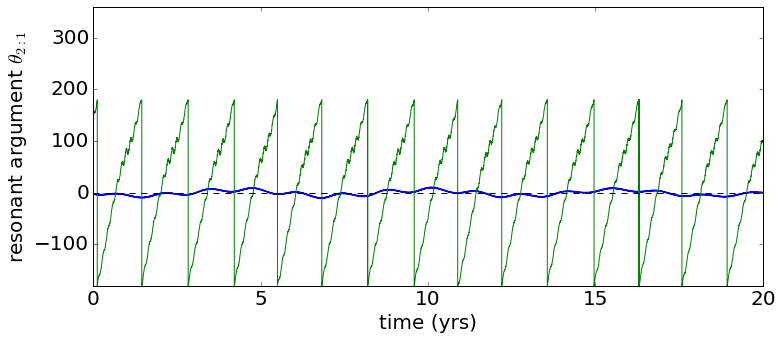

In [38]:
# Since the angle librates around 180 deg, the inner two moons are definitely in resonance.
# We can plot a similar thing for Europa and Ganymede:

theta2 = [min180To180(2.*longitude[2][i] - longitude[1][i] - varpi[1][i]) for i in range(Nout)]
#theta3 = [min180To180(-2.*longitude[2][i] + longitude[1][i] - varpi[2][i]) for i in range(Nout)]


fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111)

ax.plot(times,theta2) # period of about ten, also longer period of about 50
#ax.plot(times,theta3) # period of just less than ten
ax.set_xlim([0,20.])
ax.set_ylim([-180,360.])
ax.set_xlabel("time (yrs)", fontsize=20)
ax.set_ylabel(r"resonant argument $\theta_{2:1}$", fontsize=20)
ax.tick_params(labelsize=20)
ax.plot([0,100],[0,0],'k--')

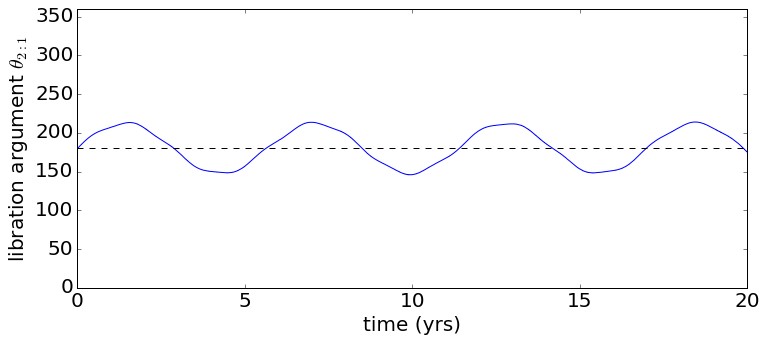

In [11]:
# This resonant angle has a shorter period oscillation of about a year, but also a longer period oscillation, 
# that can be seen.  That one has a period of about five years.

# What's peeking in here is the fact that Io, Europa and Ganymede have a Laplace 1:2:4 resonance going on,
# that causes higher harmonics in the resonance and perturbation of the moons.

# Due to their 1:2:4 resonance, they have a longer period libration argument as well:
thetaL = [zeroTo360(-longitude[0][i] + 3.*longitude[1][i] - 2.*longitude[2][i]) for i in range(Nout)]

fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111)

ax.plot(times,thetaL) # period of about 35
ax.set_xlim([0,20.])
ax.set_ylim([0,360.])
ax.set_xlabel("time (yrs)", fontsize=20)
ax.set_ylabel(r"libration argument $\theta_{2:1}$", fontsize=20)
ax.tick_params(labelsize=20)
ax.plot([0,200],[180,180],'k--')


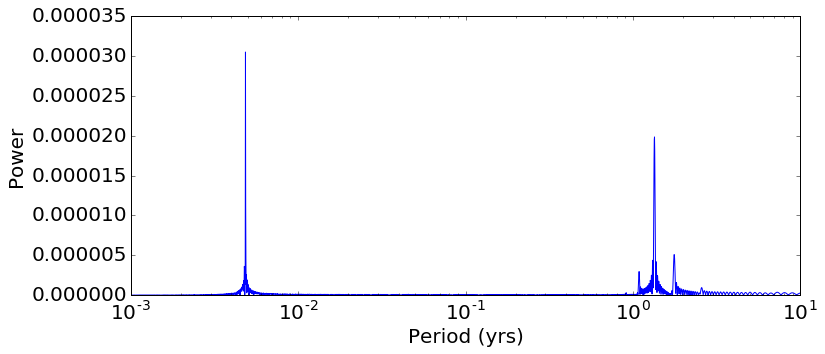

In [36]:
# looks like we've got some definite oscillations going on!
# Let's take the Fourier transform of these signals 
#- we can figure out what the periods and strengths of each of these oscillations is
from scipy import signal
Npts = 3000
# look for periodicities with periods logarithmically spaced between 0.01 yrs and 100 yrs
logPmin = np.log10(0.001)
logPmax = np.log10(10.)

# set up a logspaced array from 0.01 to 100 yrs
Ps = np.logspace(logPmin,logPmax,Npts)
# calculate an array of corresponding angular frequencies
ws = np.asarray([2*np.pi/P for P in Ps])

# calculate the periogram (for Io) (using ws as the values for which to compute it)
periodogram = signal.lombscargle(times,x[0],ws)

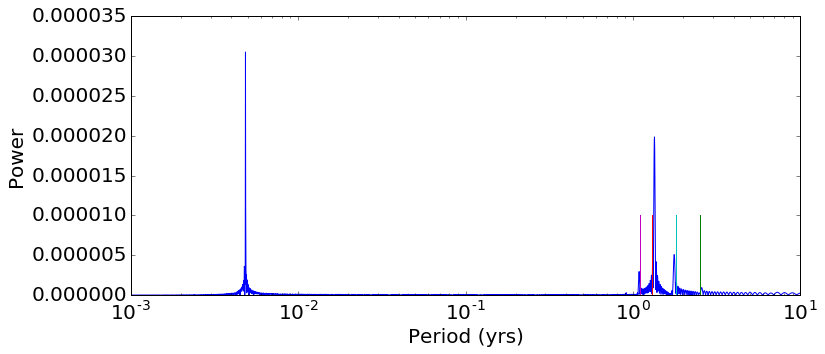

In [37]:
fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111)

#since the computed periodogram is unnormalized, taking the value A**2*N/4, we renormalize the results by applying these functions inversely
ax.plot(Ps,np.sqrt(4*periodogram/Nout))
ax.set_xscale('log')
ax.set_xlim([10**logPmin,10**logPmax])
ax.set_xlabel("Period (yrs)", fontsize=20)
ax.set_ylabel("Power", fontsize=20)
ax.tick_params(labelsize=20)


#ax.plot([2.5,2.5],[0,0.00001])
#ax.plot([1.3,1.3],[0,0.00001])  #-- big spike in the data point is the 2:1 MMR of Io and Europa
#ax.plot([1.8,1.8],[0,0.00001])
#ax.plot([1.1,1.1],[0,0.00001])


In [76]:
# The spike at about 0.005 years is just the oscillations from the orbit
# of the moon, Io.
# The other spikes around around 1 year are from the MMR of the moons: 
# the largest spike at ~1.3 years is the from the 1:2 resonance of the
# two inner moons, Io and Europa.

In [49]:
del sim